# Chang'e 5 interferometric astrometry

In this notebook we process some interferometric observations of the 8.4 GHz telemetry signal of Chang'e 5 with the goal of getting more accure right ascension and declination data for its use in orbit determination.

IQ data was recorded with antennas 2h and 4g on 2020-12-26 and 2020-12-27. In post-processing, a PLL was locked to the telemetry signal carrier on each recording in order to obtain phase measurements. Here we work with the phase output of the PLLs, subtracting the phase from antennas 2h and 4g to obtain the phase of the cross-correlation.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import scipy.signal
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, ICRS, ITRS, EarthLocation, Angle, GCRS, SkyOffsetFrame
import astropy.units as u
import astropy.constants as const
from astropy.coordinates.erfa_astrom import erfa_astrom, ErfaAstromInterpolator

# speed up Earth rotation calculations for many timestamps by using interpolation
erfa_astrom.set(ErfaAstromInterpolator(300 * u.s))

plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['figure.facecolor'] = 'w'

Here we have the observation frequencies in Hz for each of the days (taken as the received frequency at the beginning of the recording, since its precies value is not very critical), the sampling period for the phase measurements (0.1 seconds), and the baseline for 2h - 4g.

In [2]:
days = (26,27)
day_names = {d : f'2020-12-{d}' for d in days}
f_obs = dict()
f_obs[26] = 8471252500 - 17842
f_obs[27] = 8471252500 - 13477
T = 0.1
baseline_itrs = np.array([-143.72053358,  -14.20895371, -100.60231912])*u.m

The function below takes "drifting" correlations and phases them to a source. It is adapted to work at a single frequency bin using a delay measurement coming from a broadband obseration of astronomical sources.

In [3]:
def stop_baseline(t0, phase, freq, source, delay_offset = 20.35, phase_offset = -0.19*2*np.pi):
    north_radec = [source.ra.deg, source.dec.deg + 90]
    if north_radec[1] > 90:
        north_radec[1] = 180 - north_radec[1]
        north_radec[0] = 180 + north_radec[0]
    north = SkyCoord(ra = north_radec[0]*u.deg, dec = north_radec[1]*u.deg)
    
    f_obs = freq * 1e6 * u.Hz
    ts = t0 + TimeDelta(T, format = 'sec') * np.arange(phase.size)
    source_itrs = source.transform_to(ITRS(obstime = Time(ts))).cartesian
    north_itrs = north.transform_to(ITRS(obstime = Time(ts))).cartesian
    east_itrs = north_itrs.cross(source_itrs)
    vv = north_itrs.xyz.T.dot(baseline_itrs)
    uu = east_itrs.xyz.T.dot(baseline_itrs)
    ww = source_itrs.xyz.T.dot(baseline_itrs)
    w_cycles = (ww/const.c*f_obs).to(1).value
    # the delay offset was measured at 8475 MHz  and 30.72 Msps
    delay_offset_ref_freq = 8475
    delay_offset_samp_rate = 30.72
    delay_offset_phase = 2*np.pi * delay_offset * (freq - delay_offset_ref_freq)/delay_offset_samp_rate
    return (phase - 2*np.pi*w_cycles - phase_offset + delay_offset_phase,
            np.array([uu.value,vv.value,ww.value]))

## Data loading and quality check

In [4]:
# Data for 2020-12-26
# we used an initial offset of 410 seconds when reading the file
t0 = dict()
t0[26] = Time(1608996786.159047 + 410, format = 'unix')
t0[27] = Time(1609077182.170753, format = 'unix')
x0 = dict()
x1 = dict()
x0[26] = np.fromfile('/home/destevez/CE5/2020-12-26/CE5_2020-12-26T15:32:52.678235_phase_0x_1', dtype = 'float32')
x1[26] = np.fromfile('/home/destevez/CE5/2020-12-26/CE5_2020-12-26T15:32:52.678235_phase_1x_1', dtype = 'float32')
x0[27] = np.fromfile('/home/destevez/CE5/2020-12-27/CE5_2020-12-27T13:52:48.871351_phase_0x_1', dtype = 'float32')
x1[27] = np.fromfile('/home/destevez/CE5/2020-12-27/CE5_2020-12-27T13:52:48.871351_phase_1x_1', dtype = 'float32')

# compute phase differences
x = {d: x0[d][:x1[d].size] - x1[d][:x0[d].size] for d in days}

# compute time vectors
ts = {d: t0[d] + TimeDelta(T, format = 'sec') * np.arange(x[d].size) for d in days}

The figures below are just used to assess PLL lock. The phase difference rate smaller than 0.5 cycles/sample shows that both PLLs are locked.

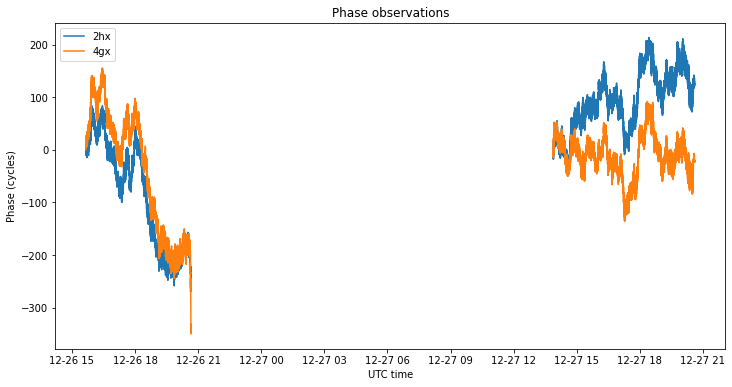

In [5]:
for d in days:
    plt.plot(ts[d].datetime, np.unwrap(x0[d])/(2*np.pi), color = 'C0')
    plt.plot(ts[d].datetime, np.unwrap(x1[d])/(2*np.pi), color = 'C1')
plt.title(f'Phase observations')
plt.ylabel('Phase (cycles)')
plt.xlabel('UTC time')
plt.legend(['2hx', '4gx'])

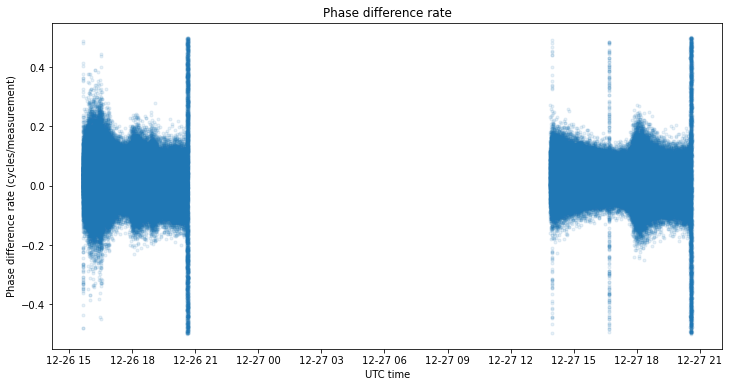

In [6]:
for d in days:
    plt.plot(ts[d].datetime[1:], np.diff(np.unwrap(x[d]))/(2*np.pi), '.', color = 'C0', alpha = 0.1)
plt.title(f'Phase difference rate')
plt.xlabel('UTC time')
plt.ylabel('Phase difference rate (cycles/measurement)');

By fitting and removing a polynomial to the phase difference data we are able to see cycle slips caused by losses of lock in the PLL. There are only a few cycle slips, which are fixed later by hand.

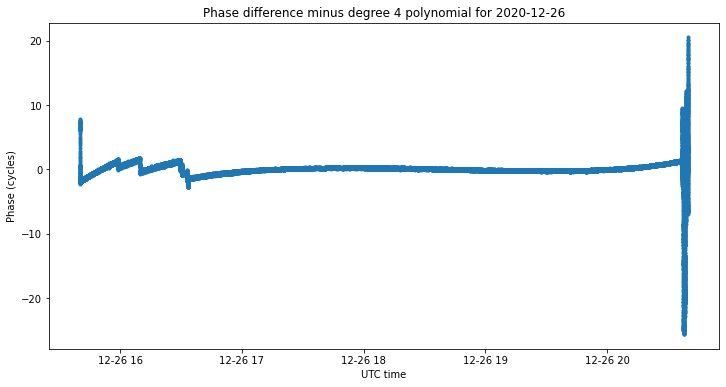

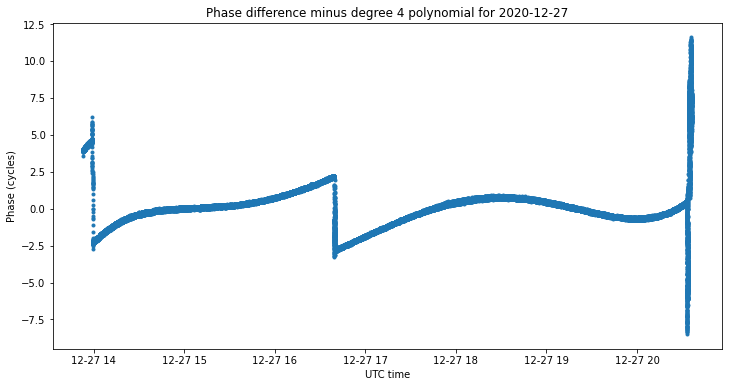

In [7]:
for d in days:
    plt.figure()
    y = np.unwrap(x[d])/(2*np.pi)
    p = np.polyfit(np.arange(y.size), y, 4)
    plt.plot(ts[d].datetime, y - np.polyval(p, np.arange(y.size)), '.')
    plt.title(f'Phase difference minus degree 4 polynomial for {day_names[d]}')
    plt.xlabel('UTC time')
    plt.ylabel('Phase (cycles)')

## Observation phasing

The phase difference data is phased to a source near enough the real spacecraft position. The dish pointing position while recording is chosen as phasing centre. This ensures that the spacecraft distance from the phasing centre will be on the order of 0.2 degrees or less.

In [8]:
source = dict()
source[26] = SkyCoord(Angle('15.317h'), Angle('-13.625d'))
source[27] = SkyCoord(Angle('15.34367h'), Angle('-14.025d'))

In [9]:
# this takes some time to run
x_stop = dict()
uvw = dict()
for d in days:
    x_stop[d], uvw[d] = stop_baseline(t0[d], x[d], f_obs[d] * 1e-6, source[d])

We plot the phased observations. The fact that there are only few phase wraps shows that the phasing algorithm is correct and the spacecraft is near the phasing centre.

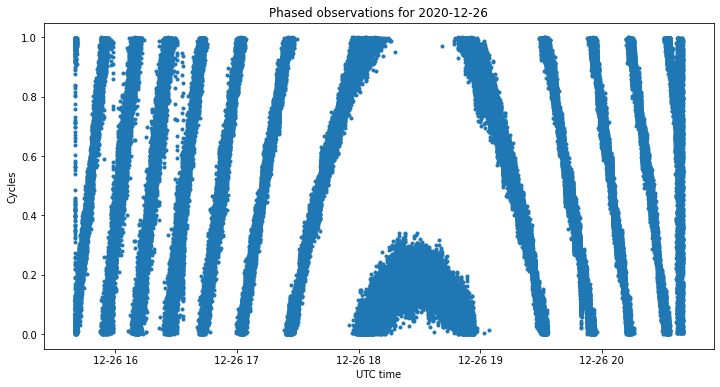

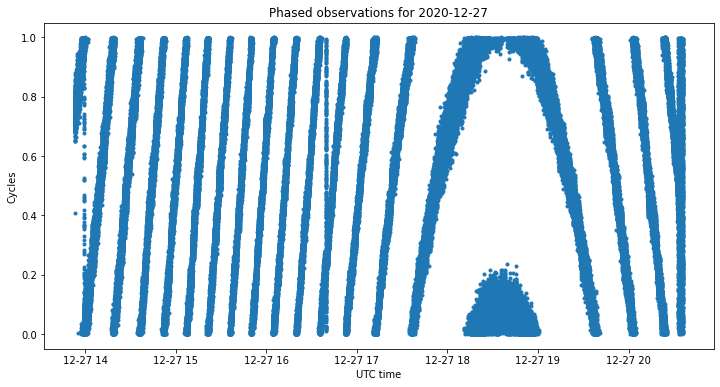

In [10]:
for d in days:
    plt.figure()
    plt.plot(ts[d].datetime, (x_stop[d] % (2*np.pi))/(2*np.pi), '.')
    plt.title(f'Phased observations for {day_names[d]}')
    plt.xlabel('UTC time')
    plt.ylabel('Phase (cycles)')

## UV coverage

Now we show the UV tracks for each observation. The U coverage is great, but the V coverage is much smaller.

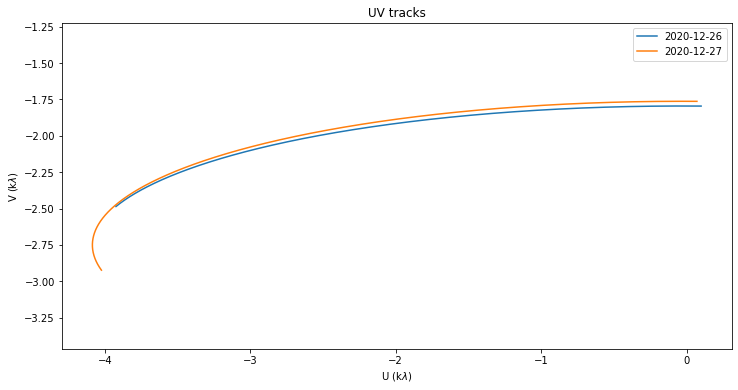

In [11]:
u_l = {d : uvw[d][0]/const.c.value*f_obs[d] for d in days} # u in lambdas
v_l = {d : uvw[d][1]/const.c.value*f_obs[d] for d in days} # v in lambdas

for d in days:
    plt.plot(u_l[d]*1e-3, v_l[d]*1e-3)
plt.axis('equal')
plt.legend(day_names.values())
plt.title('UV tracks')
plt.xlabel('U (k$\lambda$)')
plt.ylabel('V (k$\lambda$)');

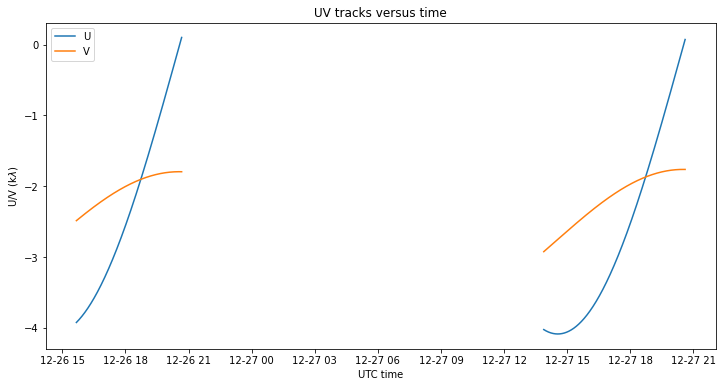

In [12]:
for d in days:
    plt.gca().set_prop_cycle(None)
    plt.plot(ts[d].datetime, uvw[d][:2].T/const.c*f_obs[d]*1e-3)
plt.title('UV tracks versus time')
plt.ylabel('U/V (k$\lambda$)')
plt.xlabel('UTC time')
plt.legend(['U', 'V']);

## Unwrapped phase observations

Now we unwrap the phase observations, manually fix cycle slips, and flag out bad segments with `np.nan`'s.

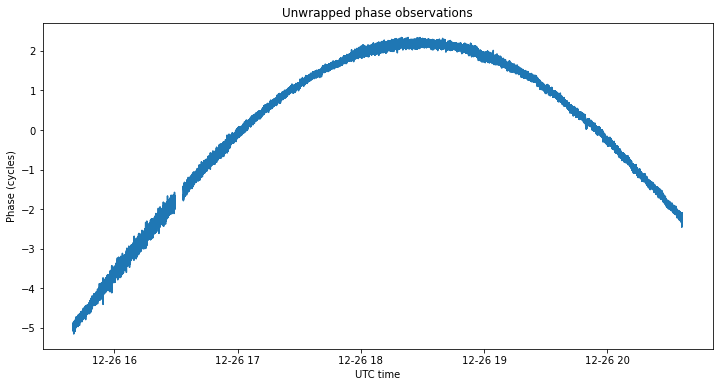

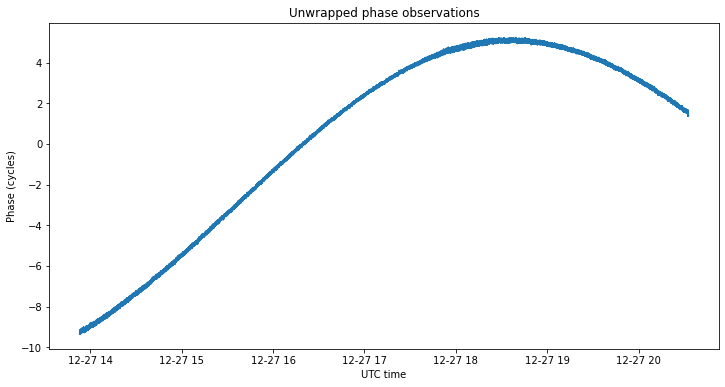

In [13]:
x_stop_unwrap = {d : np.unwrap(x_stop[d])/(2*np.pi) for d in days}

x_stop_unwrap[26][:110] = np.nan
x_stop_unwrap[26][-2250:] = np.nan
x_stop_unwrap[26][11385:11405] = np.nan
x_stop_unwrap[26][11405:] += 1
x_stop_unwrap[26][17715:17755] = np.nan
x_stop_unwrap[26][17755:] += 2
x_stop_unwrap[26][29700:32230] = np.nan
x_stop_unwrap[26][32230:] += 3

x_stop_unwrap[27][0] = np.nan
x_stop_unwrap[27][3700:3810] = np.nan
x_stop_unwrap[27][3810:] += 6
x_stop_unwrap[27][99760:100095] = np.nan
x_stop_unwrap[27][100095:] += 2
x_stop_unwrap[27][-2100:] = np.nan

# subtract integer number of cycles to centre about zero
for d in days:
    x_stop_unwrap[d] -= np.round(np.nanmean(x_stop_unwrap[d]))

for d in days:
    plt.figure()
    plt.plot(ts[d].datetime, x_stop_unwrap[d])
    plt.title('Unwrapped phase observations')
    plt.xlabel('UTC time')
    plt.ylabel('Phase (cycles)')

## Spacecraft movement model

Most of the phase change versus time seen in the figures above is due to the movement of the spacecraft in the image plane. We now create a model of this movement that consists of:

* Proper motion of the spacecraft in geocentric right-ascension and declination coordinates
* Diurnal parallax

### Proper motion

The model for the proper motion of the spacecraft is taken directly from the [Project Pluto geocentric pseudo-MPEC](https://www.projectpluto.com/temp/ch5_geo.htm), issue of 2020 Dec 31 0:55:21 UT. This almost amounts to considering a constant `dRA/dt` and `dDEC/dt` on each of the observation days, since the RA and DEC change rather slowly.

To obtain the model, we compute, for each timestamp, the difference between the ephemeris at that timestamp and the ephemeris at the beginning of the observation day. This gives the proper motion at each ellapsed time within the observation.

The ephemerides are given as a table below.

In [14]:
project_pluto = """2020 12 26 00:00  15 18 00.849   -13 08 47.24  922715  44.0   1.030  -0.839   0.684
2020 12 26 00:10  15 18 01.554   -13 08 55.63  923125  44.0   1.030  -0.838   0.684
2020 12 26 00:20  15 18 02.259   -13 09 04.01  923535  44.0   1.029  -0.837   0.683
2020 12 26 00:30  15 18 02.964   -13 09 12.38  923945  44.0   1.029  -0.837   0.683
2020 12 26 00:40  15 18 03.669   -13 09 20.75  924355  44.0   1.028  -0.836   0.683
2020 12 26 00:50  15 18 04.373   -13 09 29.11  924764  44.0   1.028  -0.836   0.683
2020 12 26 01:00  15 18 05.077   -13 09 37.46  925174  44.0   1.027  -0.835   0.682
2020 12 26 01:10  15 18 05.781   -13 09 45.81  925583  44.0   1.027  -0.835   0.682
2020 12 26 01:20  15 18 06.484   -13 09 54.16  925992  44.0   1.026  -0.834   0.682
2020 12 26 01:30  15 18 07.187   -13 10 02.50  926401  44.0   1.026  -0.833   0.682
2020 12 26 01:40  15 18 07.890   -13 10 10.83  926810  44.0   1.025  -0.833   0.681
2020 12 26 01:50  15 18 08.592   -13 10 19.15  927219  44.0   1.025  -0.832   0.681
2020 12 26 02:00  15 18 09.294   -13 10 27.47  927628  44.0   1.025  -0.832   0.681
2020 12 26 02:10  15 18 09.996   -13 10 35.79  928036  44.1   1.024  -0.831   0.681
2020 12 26 02:20  15 18 10.697   -13 10 44.10  928444  44.1   1.024  -0.831   0.680
2020 12 26 02:30  15 18 11.399   -13 10 52.40  928853  44.1   1.023  -0.830   0.680
2020 12 26 02:40  15 18 12.099   -13 11 00.70  929261  44.1   1.023  -0.829   0.680
2020 12 26 02:50  15 18 12.800   -13 11 08.99  929669  44.1   1.022  -0.829   0.680
2020 12 26 03:00  15 18 13.500   -13 11 17.28  930076  44.1   1.022  -0.828   0.680
2020 12 26 03:10  15 18 14.200   -13 11 25.56  930484  44.1   1.021  -0.828   0.679
2020 12 26 03:20  15 18 14.900   -13 11 33.83  930891  44.1   1.021  -0.827   0.679
2020 12 26 03:30  15 18 15.599   -13 11 42.10  931299  44.1   1.020  -0.827   0.679
2020 12 26 03:40  15 18 16.298   -13 11 50.37  931706  44.1   1.020  -0.826   0.679
2020 12 26 03:50  15 18 16.997   -13 11 58.62  932113  44.1   1.020  -0.825   0.678
2020 12 26 04:00  15 18 17.695   -13 12 06.88  932520  44.1   1.019  -0.825   0.678
2020 12 26 04:10  15 18 18.393   -13 12 15.12  932927  44.1   1.019  -0.824   0.678
2020 12 26 04:20  15 18 19.091   -13 12 23.36  933333  44.1   1.018  -0.824   0.678
2020 12 26 04:30  15 18 19.789   -13 12 31.60  933740  44.1   1.018  -0.823   0.677
2020 12 26 04:40  15 18 20.486   -13 12 39.83  934146  44.1   1.017  -0.823   0.677
2020 12 26 04:50  15 18 21.183   -13 12 48.05  934552  44.1   1.017  -0.822   0.677
2020 12 26 05:00  15 18 21.879   -13 12 56.27  934958  44.1   1.016  -0.821   0.677
2020 12 26 05:10  15 18 22.576   -13 13 04.48  935364  44.1   1.016  -0.821   0.676
2020 12 26 05:20  15 18 23.272   -13 13 12.69  935770  44.1   1.016  -0.820   0.676
2020 12 26 05:30  15 18 23.967   -13 13 20.89  936175  44.1   1.015  -0.820   0.676
2020 12 26 05:40  15 18 24.663   -13 13 29.09  936581  44.1   1.015  -0.819   0.676
2020 12 26 05:50  15 18 25.358   -13 13 37.28  936986  44.1   1.014  -0.819   0.675
2020 12 26 06:00  15 18 26.053   -13 13 45.47  937391  44.1   1.014  -0.818   0.675
2020 12 26 06:10  15 18 26.748   -13 13 53.65  937796  44.1   1.013  -0.818   0.675
2020 12 26 06:20  15 18 27.442   -13 14 01.82  938201  44.1   1.013  -0.817   0.675
2020 12 26 06:30  15 18 28.136   -13 14 09.99  938606  44.1   1.013  -0.817   0.674
2020 12 26 06:40  15 18 28.830   -13 14 18.15  939010  44.1   1.012  -0.816   0.674
2020 12 26 06:50  15 18 29.523   -13 14 26.31  939415  44.2   1.012  -0.815   0.674
2020 12 26 07:00  15 18 30.216   -13 14 34.46  939819  44.2   1.011  -0.815   0.674
2020 12 26 07:10  15 18 30.909   -13 14 42.61  940223  44.2   1.011  -0.814   0.674
2020 12 26 07:20  15 18 31.602   -13 14 50.75  940627  44.2   1.010  -0.814   0.673
2020 12 26 07:30  15 18 32.294   -13 14 58.89  941031  44.2   1.010  -0.813   0.673
2020 12 26 07:40  15 18 32.986   -13 15 07.02  941435  44.2   1.010  -0.813   0.673
2020 12 26 07:50  15 18 33.678   -13 15 15.14  941839  44.2   1.009  -0.812   0.673
2020 12 26 08:00  15 18 34.369   -13 15 23.26  942242  44.2   1.009  -0.812   0.672
2020 12 26 08:10  15 18 35.061   -13 15 31.38  942646  44.2   1.008  -0.811   0.672
2020 12 26 08:20  15 18 35.751   -13 15 39.49  943049  44.2   1.008  -0.811   0.672
2020 12 26 08:30  15 18 36.442   -13 15 47.59  943452  44.2   1.008  -0.810   0.672
2020 12 26 08:40  15 18 37.132   -13 15 55.69  943855  44.2   1.007  -0.809   0.671
2020 12 26 08:50  15 18 37.823   -13 16 03.78  944257  44.2   1.007  -0.809   0.671
2020 12 26 09:00  15 18 38.512   -13 16 11.87  944660  44.2   1.006  -0.808   0.671
2020 12 26 09:10  15 18 39.202   -13 16 19.96  945063  44.2   1.006  -0.808   0.671
2020 12 26 09:20  15 18 39.891   -13 16 28.03  945465  44.2   1.005  -0.807   0.671
2020 12 26 09:30  15 18 40.580   -13 16 36.11  945867  44.2   1.005  -0.807   0.670
2020 12 26 09:40  15 18 41.269   -13 16 44.17  946269  44.2   1.005  -0.806   0.670
2020 12 26 09:50  15 18 41.958   -13 16 52.23  946671  44.2   1.004  -0.806   0.670
2020 12 26 10:00  15 18 42.646   -13 17 00.29  947073  44.2   1.004  -0.805   0.670
2020 12 26 10:10  15 18 43.334   -13 17 08.34  947475  44.2   1.003  -0.805   0.669
2020 12 26 10:20  15 18 44.021   -13 17 16.39  947876  44.2   1.003  -0.804   0.669
2020 12 26 10:30  15 18 44.709   -13 17 24.43  948278  44.2   1.003  -0.804   0.669
2020 12 26 10:40  15 18 45.396   -13 17 32.46  948679  44.2   1.002  -0.803   0.669
2020 12 26 10:50  15 18 46.083   -13 17 40.49  949080  44.2   1.002  -0.803   0.668
2020 12 26 11:00  15 18 46.770   -13 17 48.52  949481  44.2   1.002  -0.802   0.668
2020 12 26 11:10  15 18 47.456   -13 17 56.54  949882  44.2   1.001  -0.802   0.668
2020 12 26 11:20  15 18 48.142   -13 18 04.55  950282  44.2   1.001  -0.801   0.668
2020 12 26 11:30  15 18 48.828   -13 18 12.56  950683  44.3   1.000  -0.801   0.668
2020 12 26 11:40  15 18 49.513   -13 18 20.57  951083  44.3   1.000  -0.800   0.667
2020 12 26 11:50  15 18 50.199   -13 18 28.57  951484  44.3   1.000  -0.800   0.667
2020 12 26 12:00  15 18 50.884   -13 18 36.56  951884  44.3   0.999  -0.799   0.667
2020 12 26 12:10  15 18 51.569   -13 18 44.55  952284  44.3   0.999  -0.799   0.667
2020 12 26 12:20  15 18 52.253   -13 18 52.54  952684  44.3   0.998  -0.798   0.666
2020 12 26 12:30  15 18 52.938   -13 19 00.52  953083  44.3   0.998  -0.798   0.666
2020 12 26 12:40  15 18 53.622   -13 19 08.49  953483  44.3   0.998  -0.797   0.666
2020 12 26 12:50  15 18 54.305   -13 19 16.46  953882  44.3   0.997  -0.797   0.666
2020 12 26 13:00  15 18 54.989   -13 19 24.42  954282  44.3   0.997  -0.796   0.665
2020 12 26 13:10  15 18 55.672   -13 19 32.38  954681  44.3   0.997  -0.796   0.665
2020 12 26 13:20  15 18 56.355   -13 19 40.33  955080  44.3   0.996  -0.795   0.665
2020 12 26 13:30  15 18 57.038   -13 19 48.28  955479  44.3   0.996  -0.795   0.665
2020 12 26 13:40  15 18 57.721   -13 19 56.23  955878  44.3   0.995  -0.794   0.665
2020 12 26 13:50  15 18 58.403   -13 20 04.17  956276  44.3   0.995  -0.794   0.664
2020 12 26 14:00  15 18 59.085   -13 20 12.10  956675  44.3   0.995  -0.793   0.664
2020 12 26 14:10  15 18 59.767   -13 20 20.03  957073  44.3   0.994  -0.793   0.664
2020 12 26 14:20  15 19 00.449   -13 20 27.95  957471  44.3   0.994  -0.792   0.664
2020 12 26 14:30  15 19 01.130   -13 20 35.87  957869  44.3   0.994  -0.792   0.663
2020 12 26 14:40  15 19 01.811   -13 20 43.78  958267  44.3   0.993  -0.791   0.663
2020 12 26 14:50  15 19 02.492   -13 20 51.69  958665  44.3   0.993  -0.791   0.663
2020 12 26 15:00  15 19 03.172   -13 20 59.60  959063  44.3   0.993  -0.790   0.663
2020 12 26 15:10  15 19 03.853   -13 21 07.50  959460  44.3   0.992  -0.790   0.663
2020 12 26 15:20  15 19 04.533   -13 21 15.39  959858  44.3   0.992  -0.789   0.662
2020 12 26 15:30  15 19 05.213   -13 21 23.28  960255  44.3   0.991  -0.789   0.662
2020 12 26 15:40  15 19 05.892   -13 21 31.16  960652  44.3   0.991  -0.788   0.662
2020 12 26 15:50  15 19 06.572   -13 21 39.04  961049  44.3   0.991  -0.788   0.662
2020 12 26 16:00  15 19 07.251   -13 21 46.92  961446  44.4   0.990  -0.787   0.661
2020 12 26 16:10  15 19 07.930   -13 21 54.79  961843  44.4   0.990  -0.787   0.661
2020 12 26 16:20  15 19 08.609   -13 22 02.65  962240  44.4   0.990  -0.786   0.661
2020 12 26 16:30  15 19 09.287   -13 22 10.51  962636  44.4   0.989  -0.786   0.661
2020 12 26 16:40  15 19 09.965   -13 22 18.37  963032  44.4   0.989  -0.785   0.661
2020 12 26 16:50  15 19 10.643   -13 22 26.22  963429  44.4   0.989  -0.785   0.660
2020 12 26 17:00  15 19 11.321   -13 22 34.06  963825  44.4   0.988  -0.784   0.660
2020 12 26 17:10  15 19 11.999   -13 22 41.90  964221  44.4   0.988  -0.784   0.660
2020 12 26 17:20  15 19 12.676   -13 22 49.74  964617  44.4   0.988  -0.783   0.660
2020 12 26 17:30  15 19 13.353   -13 22 57.57  965012  44.4   0.987  -0.783   0.659
2020 12 26 17:40  15 19 14.030   -13 23 05.39  965408  44.4   0.987  -0.782   0.659
2020 12 26 17:50  15 19 14.707   -13 23 13.22  965803  44.4   0.987  -0.782   0.659
2020 12 26 18:00  15 19 15.383   -13 23 21.03  966198  44.4   0.986  -0.781   0.659
2020 12 26 18:10  15 19 16.059   -13 23 28.84  966594  44.4   0.986  -0.781   0.659
2020 12 26 18:20  15 19 16.735   -13 23 36.65  966989  44.4   0.986  -0.780   0.658
2020 12 26 18:30  15 19 17.411   -13 23 44.45  967383  44.4   0.985  -0.780   0.658
2020 12 26 18:40  15 19 18.086   -13 23 52.25  967778  44.4   0.985  -0.779   0.658
2020 12 26 18:50  15 19 18.762   -13 24 00.04  968173  44.4   0.985  -0.779   0.658
2020 12 26 19:00  15 19 19.437   -13 24 07.83  968567  44.4   0.984  -0.778   0.657
2020 12 26 19:10  15 19 20.112   -13 24 15.62  968962  44.4   0.984  -0.778   0.657
2020 12 26 19:20  15 19 20.786   -13 24 23.39  969356  44.4   0.984  -0.778   0.657
2020 12 26 19:30  15 19 21.461   -13 24 31.17  969750  44.4   0.983  -0.777   0.657
2020 12 26 19:40  15 19 22.135   -13 24 38.94  970144  44.4   0.983  -0.777   0.657
2020 12 26 19:50  15 19 22.809   -13 24 46.70  970538  44.4   0.983  -0.776   0.656
2020 12 26 20:00  15 19 23.482   -13 24 54.46  970932  44.4   0.982  -0.776   0.656
2020 12 26 20:10  15 19 24.156   -13 25 02.22  971325  44.4   0.982  -0.775   0.656
2020 12 26 20:20  15 19 24.829   -13 25 09.97  971719  44.4   0.982  -0.775   0.656
2020 12 26 20:30  15 19 25.502   -13 25 17.72  972112  44.5   0.981  -0.774   0.655
2020 12 26 20:40  15 19 26.175   -13 25 25.46  972505  44.5   0.981  -0.774   0.655
2020 12 26 20:50  15 19 26.848   -13 25 33.19  972898  44.5   0.981  -0.773   0.655
2020 12 26 21:00  15 19 27.520   -13 25 40.93  973291  44.5   0.980  -0.773   0.655
2020 12 26 21:10  15 19 28.193   -13 25 48.65  973684  44.5   0.980  -0.772   0.655
2020 12 26 21:20  15 19 28.865   -13 25 56.38  974076  44.5   0.980  -0.772   0.654
2020 12 26 21:30  15 19 29.537   -13 26 04.10  974469  44.5   0.979  -0.772   0.654
2020 12 26 21:40  15 19 30.208   -13 26 11.81  974861  44.5   0.979  -0.771   0.654
2020 12 26 21:50  15 19 30.880   -13 26 19.52  975254  44.5   0.979  -0.771   0.654
2020 12 26 22:00  15 19 31.551   -13 26 27.23  975646  44.5   0.978  -0.770   0.653
2020 12 26 22:10  15 19 32.222   -13 26 34.93  976038  44.5   0.978  -0.770   0.653
2020 12 26 22:20  15 19 32.892   -13 26 42.62  976430  44.5   0.978  -0.769   0.653
2020 12 26 22:30  15 19 33.563   -13 26 50.31  976821  44.5   0.978  -0.769   0.653
2020 12 26 22:40  15 19 34.233   -13 26 58.00  977213  44.5   0.977  -0.768   0.653
2020 12 26 22:50  15 19 34.904   -13 27 05.68  977604  44.5   0.977  -0.768   0.652
2020 12 26 23:00  15 19 35.574   -13 27 13.36  977996  44.5   0.977  -0.767   0.652
2020 12 26 23:10  15 19 36.243   -13 27 21.03  978387  44.5   0.976  -0.767   0.652
2020 12 26 23:20  15 19 36.913   -13 27 28.70  978778  44.5   0.976  -0.767   0.652
2020 12 26 23:30  15 19 37.582   -13 27 36.37  979169  44.5   0.976  -0.766   0.652
2020 12 26 23:40  15 19 38.251   -13 27 44.03  979560  44.5   0.975  -0.766   0.651
2020 12 26 23:50  15 19 38.920   -13 27 51.68  979951  44.5   0.975  -0.765   0.651
2020 12 27 00:00  15 19 39.589   -13 27 59.33  980341  44.5   0.975  -0.765   0.651
2020 12 27 00:10  15 19 40.258   -13 28 06.98  980732  44.5   0.975  -0.764   0.651
2020 12 27 00:20  15 19 40.926   -13 28 14.62  981122  44.5   0.974  -0.764   0.650
2020 12 27 00:30  15 19 41.594   -13 28 22.26  981512  44.5   0.974  -0.763   0.650
2020 12 27 00:40  15 19 42.262   -13 28 29.89  981902  44.5   0.974  -0.763   0.650
2020 12 27 00:50  15 19 42.930   -13 28 37.52  982292  44.5   0.973  -0.763   0.650
2020 12 27 01:00  15 19 43.598   -13 28 45.15  982682  44.6   0.973  -0.762   0.650
2020 12 27 01:10  15 19 44.265   -13 28 52.77  983072  44.6   0.973  -0.762   0.649
2020 12 27 01:20  15 19 44.932   -13 29 00.38  983461  44.6   0.972  -0.761   0.649
2020 12 27 01:30  15 19 45.599   -13 29 08.00  983851  44.6   0.972  -0.761   0.649
2020 12 27 01:40  15 19 46.266   -13 29 15.60  984240  44.6   0.972  -0.760   0.649
2020 12 27 01:50  15 19 46.933   -13 29 23.21  984629  44.6   0.972  -0.760   0.649
2020 12 27 02:00  15 19 47.599   -13 29 30.80  985018  44.6   0.971  -0.760   0.648
2020 12 27 02:10  15 19 48.265   -13 29 38.40  985407  44.6   0.971  -0.759   0.648
2020 12 27 02:20  15 19 48.931   -13 29 45.99  985796  44.6   0.971  -0.759   0.648
2020 12 27 02:30  15 19 49.597   -13 29 53.57  986185  44.6   0.970  -0.758   0.648
2020 12 27 02:40  15 19 50.263   -13 30 01.15  986573  44.6   0.970  -0.758   0.648
2020 12 27 02:50  15 19 50.928   -13 30 08.73  986962  44.6   0.970  -0.757   0.647
2020 12 27 03:00  15 19 51.594   -13 30 16.30  987350  44.6   0.970  -0.757   0.647
2020 12 27 03:10  15 19 52.259   -13 30 23.87  987738  44.6   0.969  -0.757   0.647
2020 12 27 03:20  15 19 52.924   -13 30 31.44  988126  44.6   0.969  -0.756   0.647
2020 12 27 03:30  15 19 53.588   -13 30 39.00  988514  44.6   0.969  -0.756   0.646
2020 12 27 03:40  15 19 54.253   -13 30 46.55  988902  44.6   0.969  -0.755   0.646
2020 12 27 03:50  15 19 54.917   -13 30 54.10  989290  44.6   0.968  -0.755   0.646
2020 12 27 04:00  15 19 55.581   -13 31 01.65  989677  44.6   0.968  -0.754   0.646
2020 12 27 04:10  15 19 56.245   -13 31 09.19  990065  44.6   0.968  -0.754   0.646
2020 12 27 04:20  15 19 56.909   -13 31 16.73  990452  44.6   0.967  -0.754   0.645
2020 12 27 04:30  15 19 57.573   -13 31 24.27  990839  44.6   0.967  -0.753   0.645
2020 12 27 04:40  15 19 58.236   -13 31 31.80  991226  44.6   0.967  -0.753   0.645
2020 12 27 04:50  15 19 58.900   -13 31 39.32  991613  44.6   0.967  -0.752   0.645
2020 12 27 05:00  15 19 59.563   -13 31 46.85  992000  44.6   0.966  -0.752   0.645
2020 12 27 05:10  15 20 00.226   -13 31 54.36  992386  44.6   0.966  -0.751   0.644
2020 12 27 05:20  15 20 00.889   -13 32 01.88  992773  44.7   0.966  -0.751   0.644
2020 12 27 05:30  15 20 01.551   -13 32 09.39  993159  44.7   0.966  -0.751   0.644
2020 12 27 05:40  15 20 02.214   -13 32 16.89  993546  44.7   0.965  -0.750   0.644
2020 12 27 05:50  15 20 02.876   -13 32 24.39  993932  44.7   0.965  -0.750   0.644
2020 12 27 06:00  15 20 03.538   -13 32 31.89  994318  44.7   0.965  -0.749   0.643
2020 12 27 06:10  15 20 04.200   -13 32 39.38  994704  44.7   0.965  -0.749   0.643
2020 12 27 06:20  15 20 04.862   -13 32 46.87  995090  44.7   0.964  -0.749   0.643
2020 12 27 06:30  15 20 05.523   -13 32 54.36  995475  44.7   0.964  -0.748   0.643
2020 12 27 06:40  15 20 06.185   -13 33 01.84  995861  44.7   0.964  -0.748   0.643
2020 12 27 06:50  15 20 06.846   -13 33 09.31  996246  44.7   0.964  -0.747   0.642
2020 12 27 07:00  15 20 07.507   -13 33 16.78  996632  44.7   0.963  -0.747   0.642
2020 12 27 07:10  15 20 08.168   -13 33 24.25  997017  44.7   0.963  -0.747   0.642
2020 12 27 07:20  15 20 08.828   -13 33 31.72  997402  44.7   0.963  -0.746   0.642
2020 12 27 07:30  15 20 09.489   -13 33 39.18  997787  44.7   0.963  -0.746   0.641
2020 12 27 07:40  15 20 10.149   -13 33 46.63  998172  44.7   0.962  -0.745   0.641
2020 12 27 07:50  15 20 10.810   -13 33 54.08  998556  44.7   0.962  -0.745   0.641
2020 12 27 08:00  15 20 11.470   -13 34 01.53  998941  44.7   0.962  -0.744   0.641
2020 12 27 08:10  15 20 12.129   -13 34 08.98  999325  44.7   0.962  -0.744   0.641
2020 12 27 08:20  15 20 12.789   -13 34 16.42  999710  44.7   0.961  -0.744   0.640
2020 12 27 08:30  15 20 13.449   -13 34 23.85  .00669  44.7   0.961  -0.743   0.640
2020 12 27 08:40  15 20 14.108   -13 34 31.28  .00669  44.7   0.961  -0.743   0.640
2020 12 27 08:50  15 20 14.767   -13 34 38.71  .00669  44.7   0.961  -0.742   0.640
2020 12 27 09:00  15 20 15.426   -13 34 46.14  .00669  44.7   0.960  -0.742   0.640
2020 12 27 09:10  15 20 16.085   -13 34 53.56  .00670  44.7   0.960  -0.742   0.639
2020 12 27 09:20  15 20 16.744   -13 35 00.97  .00670  44.7   0.960  -0.741   0.639
2020 12 27 09:30  15 20 17.403   -13 35 08.38  .00670  44.7   0.960  -0.741   0.639
2020 12 27 09:40  15 20 18.061   -13 35 15.79  .00670  44.7   0.959  -0.740   0.639
2020 12 27 09:50  15 20 18.719   -13 35 23.20  .00671  44.8   0.959  -0.740   0.639
2020 12 27 10:00  15 20 19.378   -13 35 30.60  .00671  44.8   0.959  -0.740   0.638
2020 12 27 10:10  15 20 20.036   -13 35 37.99  .00671  44.8   0.959  -0.739   0.638
2020 12 27 10:20  15 20 20.693   -13 35 45.38  .00671  44.8   0.958  -0.739   0.638
2020 12 27 10:30  15 20 21.351   -13 35 52.77  .00672  44.8   0.958  -0.739   0.638
2020 12 27 10:40  15 20 22.009   -13 36 00.16  .00672  44.8   0.958  -0.738   0.638
2020 12 27 10:50  15 20 22.666   -13 36 07.54  .00672  44.8   0.958  -0.738   0.637
2020 12 27 11:00  15 20 23.323   -13 36 14.91  .00672  44.8   0.957  -0.737   0.637
2020 12 27 11:10  15 20 23.980   -13 36 22.29  .00673  44.8   0.957  -0.737   0.637
2020 12 27 11:20  15 20 24.637   -13 36 29.65  .00673  44.8   0.957  -0.737   0.637
2020 12 27 11:30  15 20 25.294   -13 36 37.02  .00673  44.8   0.957  -0.736   0.637
2020 12 27 11:40  15 20 25.950   -13 36 44.38  .00673  44.8   0.957  -0.736   0.636
2020 12 27 11:50  15 20 26.607   -13 36 51.74  .00674  44.8   0.956  -0.735   0.636
2020 12 27 12:00  15 20 27.263   -13 36 59.09  .00674  44.8   0.956  -0.735   0.636
2020 12 27 12:10  15 20 27.919   -13 37 06.44  .00674  44.8   0.956  -0.735   0.636
2020 12 27 12:20  15 20 28.575   -13 37 13.79  .00674  44.8   0.956  -0.734   0.636
2020 12 27 12:30  15 20 29.231   -13 37 21.13  .00675  44.8   0.955  -0.734   0.635
2020 12 27 12:40  15 20 29.887   -13 37 28.46  .00675  44.8   0.955  -0.733   0.635
2020 12 27 12:50  15 20 30.542   -13 37 35.80  .00675  44.8   0.955  -0.733   0.635
2020 12 27 13:00  15 20 31.198   -13 37 43.13  .00675  44.8   0.955  -0.733   0.635
2020 12 27 13:10  15 20 31.853   -13 37 50.46  .00676  44.8   0.955  -0.732   0.635
2020 12 27 13:20  15 20 32.508   -13 37 57.78  .00676  44.8   0.954  -0.732   0.634
2020 12 27 13:30  15 20 33.163   -13 38 05.10  .00676  44.8   0.954  -0.732   0.634
2020 12 27 13:40  15 20 33.818   -13 38 12.41  .00676  44.8   0.954  -0.731   0.634
2020 12 27 13:50  15 20 34.473   -13 38 19.72  .00677  44.8   0.954  -0.731   0.634
2020 12 27 14:00  15 20 35.127   -13 38 27.03  .00677  44.8   0.953  -0.730   0.634
2020 12 27 14:10  15 20 35.782   -13 38 34.33  .00677  44.9   0.953  -0.730   0.633
2020 12 27 14:20  15 20 36.436   -13 38 41.63  .00677  44.9   0.953  -0.730   0.633
2020 12 27 14:30  15 20 37.090   -13 38 48.93  .00678  44.9   0.953  -0.729   0.633
2020 12 27 14:40  15 20 37.744   -13 38 56.22  .00678  44.9   0.953  -0.729   0.633
2020 12 27 14:50  15 20 38.398   -13 39 03.51  .00678  44.9   0.952  -0.729   0.633
2020 12 27 15:00  15 20 39.052   -13 39 10.80  .00678  44.9   0.952  -0.728   0.632
2020 12 27 15:10  15 20 39.705   -13 39 18.08  .00679  44.9   0.952  -0.728   0.632
2020 12 27 15:20  15 20 40.359   -13 39 25.36  .00679  44.9   0.952  -0.727   0.632
2020 12 27 15:30  15 20 41.012   -13 39 32.63  .00679  44.9   0.952  -0.727   0.632
2020 12 27 15:40  15 20 41.665   -13 39 39.90  .00679  44.9   0.951  -0.727   0.632
2020 12 27 15:50  15 20 42.318   -13 39 47.17  .00680  44.9   0.951  -0.726   0.631
2020 12 27 16:00  15 20 42.971   -13 39 54.43  .00680  44.9   0.951  -0.726   0.631
2020 12 27 16:10  15 20 43.624   -13 40 01.69  .00680  44.9   0.951  -0.726   0.631
2020 12 27 16:20  15 20 44.276   -13 40 08.94  .00681  44.9   0.951  -0.725   0.631
2020 12 27 16:30  15 20 44.929   -13 40 16.20  .00681  44.9   0.950  -0.725   0.631
2020 12 27 16:40  15 20 45.581   -13 40 23.44  .00681  44.9   0.950  -0.725   0.630
2020 12 27 16:50  15 20 46.234   -13 40 30.69  .00681  44.9   0.950  -0.724   0.630
2020 12 27 17:00  15 20 46.886   -13 40 37.93  .00682  44.9   0.950  -0.724   0.630
2020 12 27 17:10  15 20 47.538   -13 40 45.17  .00682  44.9   0.950  -0.723   0.630
2020 12 27 17:20  15 20 48.189   -13 40 52.40  .00682  44.9   0.949  -0.723   0.630
2020 12 27 17:30  15 20 48.841   -13 40 59.63  .00682  44.9   0.949  -0.723   0.629
2020 12 27 17:40  15 20 49.493   -13 41 06.86  .00683  44.9   0.949  -0.722   0.629
2020 12 27 17:50  15 20 50.144   -13 41 14.08  .00683  44.9   0.949  -0.722   0.629
2020 12 27 18:00  15 20 50.796   -13 41 21.30  .00683  44.9   0.949  -0.722   0.629
2020 12 27 18:10  15 20 51.447   -13 41 28.51  .00683  44.9   0.948  -0.721   0.629
2020 12 27 18:20  15 20 52.098   -13 41 35.73  .00684  45.0   0.948  -0.721   0.629
2020 12 27 18:30  15 20 52.749   -13 41 42.93  .00684  45.0   0.948  -0.721   0.628
2020 12 27 18:40  15 20 53.400   -13 41 50.14  .00684  45.0   0.948  -0.720   0.628
2020 12 27 18:50  15 20 54.050   -13 41 57.34  .00684  45.0   0.948  -0.720   0.628
2020 12 27 19:00  15 20 54.701   -13 42 04.54  .00685  45.0   0.948  -0.720   0.628
2020 12 27 19:10  15 20 55.352   -13 42 11.73  .00685  45.0   0.947  -0.719   0.628
2020 12 27 19:20  15 20 56.002   -13 42 18.92  .00685  45.0   0.947  -0.719   0.627
2020 12 27 19:30  15 20 56.652   -13 42 26.11  .00685  45.0   0.947  -0.718   0.627
2020 12 27 19:40  15 20 57.302   -13 42 33.29  .00686  45.0   0.947  -0.718   0.627
2020 12 27 19:50  15 20 57.952   -13 42 40.47  .00686  45.0   0.947  -0.718   0.627
2020 12 27 20:00  15 20 58.602   -13 42 47.65  .00686  45.0   0.946  -0.717   0.627
2020 12 27 20:10  15 20 59.252   -13 42 54.82  .00686  45.0   0.946  -0.717   0.626
2020 12 27 20:20  15 20 59.901   -13 43 01.99  .00687  45.0   0.946  -0.717   0.626
2020 12 27 20:30  15 21 00.551   -13 43 09.16  .00687  45.0   0.946  -0.716   0.626
2020 12 27 20:40  15 21 01.200   -13 43 16.32  .00687  45.0   0.946  -0.716   0.626
2020 12 27 20:50  15 21 01.850   -13 43 23.48  .00687  45.0   0.946  -0.716   0.626
2020 12 27 21:00  15 21 02.499   -13 43 30.64  .00688  45.0   0.945  -0.715   0.625
2020 12 27 21:10  15 21 03.148   -13 43 37.79  .00688  45.0   0.945  -0.715   0.625
2020 12 27 21:20  15 21 03.797   -13 43 44.94  .00688  45.0   0.945  -0.715   0.625
2020 12 27 21:30  15 21 04.446   -13 43 52.08  .00688  45.0   0.945  -0.714   0.625
2020 12 27 21:40  15 21 05.094   -13 43 59.22  .00689  45.0   0.945  -0.714   0.625
2020 12 27 21:50  15 21 05.743   -13 44 06.36  .00689  45.0   0.944  -0.714   0.624
2020 12 27 22:00  15 21 06.391   -13 44 13.50  .00689  45.0   0.944  -0.713   0.624
2020 12 27 22:10  15 21 07.040   -13 44 20.63  .00689  45.0   0.944  -0.713   0.624
2020 12 27 22:20  15 21 07.688   -13 44 27.76  .00690  45.0   0.944  -0.713   0.624
2020 12 27 22:30  15 21 08.336   -13 44 34.88  .00690  45.0   0.944  -0.712   0.624
2020 12 27 22:40  15 21 08.984   -13 44 42.00  .00690  45.1   0.944  -0.712   0.624
2020 12 27 22:50  15 21 09.632   -13 44 49.12  .00690  45.1   0.943  -0.712   0.623
2020 12 27 23:00  15 21 10.280   -13 44 56.23  .00691  45.1   0.943  -0.711   0.623
2020 12 27 23:10  15 21 10.928   -13 45 03.35  .00691  45.1   0.943  -0.711   0.623
2020 12 27 23:20  15 21 11.575   -13 45 10.45  .00691  45.1   0.943  -0.710   0.623
2020 12 27 23:30  15 21 12.223   -13 45 17.56  .00691  45.1   0.943  -0.710   0.623
2020 12 27 23:40  15 21 12.870   -13 45 24.66  .00692  45.1   0.943  -0.710   0.622
2020 12 27 23:50  15 21 13.518   -13 45 31.76  .00692  45.1   0.942  -0.709   0.622"""

We read the table and interpolate the measurement timestamps.

In [15]:
pluto_t = Time([np.datetime64('{}-{}-{}T{}'.format(*l.split()[:4])) for l in project_pluto.split('\n')])
pluto_ra = Angle(['{}h{}m{}s'.format(*l.split()[4:7]) for l in project_pluto.split('\n')])
pluto_dec = Angle(['{}d{}m{}s'.format(*l.split()[7:10]) for l in project_pluto.split('\n')])

pluto_ra_interp = {d : np.interp(ts[d].jd, pluto_t.jd, pluto_ra) for d in days}
pluto_dec_interp = {d : np.interp(ts[d].jd, pluto_t.jd, pluto_dec) for d in days}

We plot the difference between the ephemerides from Project Pluto and the phasing centre we've chosen. This shows that the proper motion is almost linear with time (constant `dRA/dt` and `dDEC/dt`).

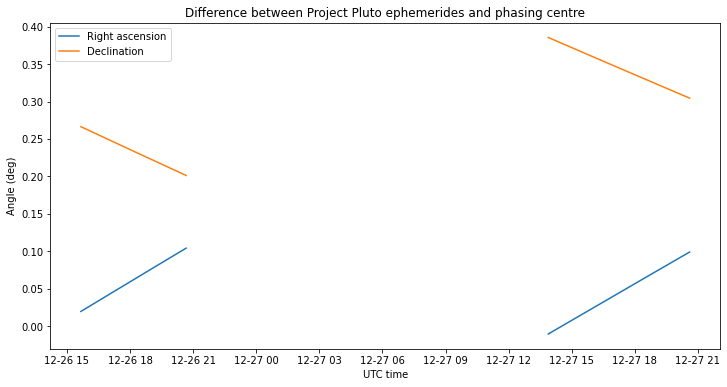

In [16]:
for d in days:
    plt.plot(ts[d].datetime, (pluto_ra_interp[d] - source[d].ra).deg, color = 'C0')
    plt.plot(ts[d].datetime, (pluto_dec_interp[d] - source[d].dec).deg, color = 'C1')
plt.legend(['Right ascension', 'Declination'])
plt.xlabel('UTC time')
plt.ylabel('Angle (deg)')
plt.title('Difference between Project Pluto ephemerides and phasing centre');

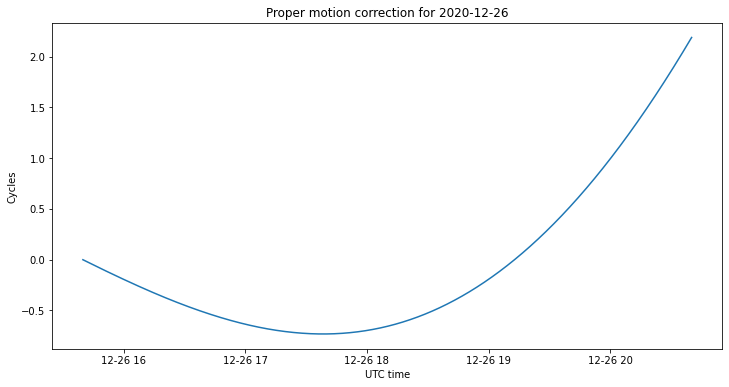

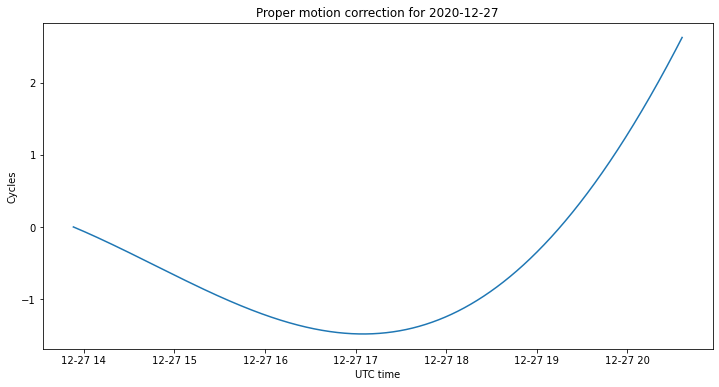

In [17]:
pm_correction = dict()
for d in days:
    pm_correction[d] = (pluto_ra_interp[d] - pluto_ra_interp[d][0]).rad * u_l[d] \
                    + (pluto_dec_interp[d] - pluto_dec_interp[d][0]).rad * v_l[d]
for d in days:
    plt.figure()
    plt.plot(ts[d].datetime, pm_correction[d])
    plt.title(f'Proper motion correction for {day_names[d]}')
    plt.xlabel('UTC time')
    plt.ylabel('Cycles')

## Diurnal parallax

For the calculation of diurnal parallax we use the geocentric ephemerides from Project Pluto. We compute displacement in right-ascension and declination as seen from ATA for these ephemerides. Then we apply that displacement directly to the phasing centre, even though it's not the same as the Project Pluto ephemerides.

In [18]:
pluto_dist = [float(l.split()[10]) for l in project_pluto.split('\n')]
pluto_dist = [(a * (u.km if a > 1 else u.au)).to(u.km).value for a in pluto_dist]
pluto_dist_interp = {d : np.interp(ts[d].jd, pluto_t.jd, pluto_dist) for d in days}

In [19]:
source_gcrs = {d : GCRS(ra = pluto_ra_interp[d], dec = pluto_dec_interp[d],
                        distance = pluto_dist_interp[d] * u.km)
               for d in days}
ata = EarthLocation(lat = '40d49m03s', lon = '-121d28m24s', height = 1008*u.m)

We now compute ATA-centric right ascension and declination. This is done by computing the ATA position in GCRS coordinates for each timestamp, computing the vector joining ATA and the source (which is naturally in GCRS coordinates) in cartesian coordinates, and then converting to spherical coordinates.

In [20]:
# this takes some time to run
p = {d : source_gcrs[d].cartesian - ata.get_gcrs(ts[d]).cartesian for d in days}

In [21]:
ra_paral = {d : Angle(np.angle(p[d].xyz.value[0,:] + 1j*p[d].xyz.value[1,:])*u.rad).wrap_at('360d')
            for d in days}
dec_paral = {d : Angle(np.angle(np.abs(p[d].xyz.value[0,:] + 1j*p[d].xyz.value[1,:])\
                                + 1j*p[d].xyz.value[2,:])*u.rad)
             for d in days}

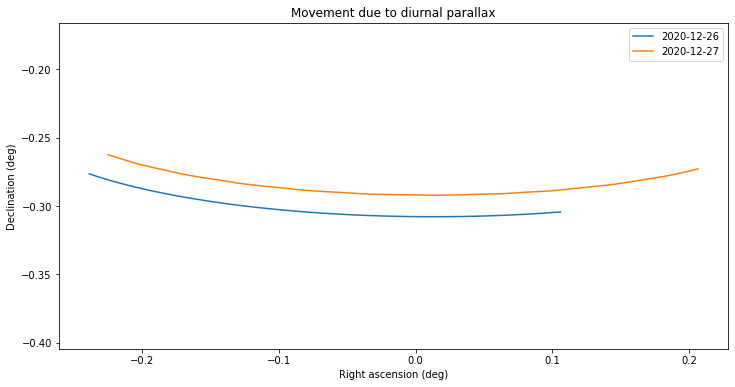

In [22]:
for d in days:
    plt.plot((ra_paral[d] - pluto_ra_interp[d]).deg, (dec_paral[d] - pluto_dec_interp[d]).deg)
plt.axis('equal')
plt.legend(day_names.values())
plt.title('Movement due to diurnal parallax')
plt.xlabel('Right ascension (deg)')
plt.ylabel('Declination (deg)');

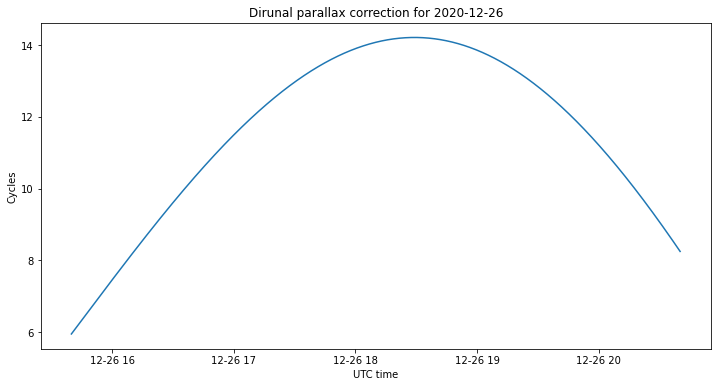

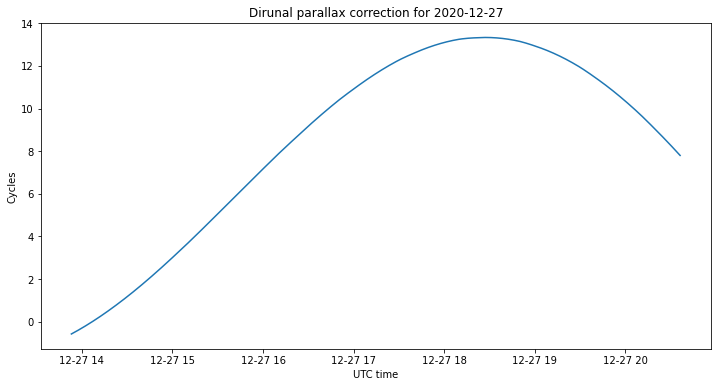

In [23]:
parallax_correction = {d : (ra_paral[d] - pluto_ra_interp[d]).rad * u_l[d] \
                           + (dec_paral[d] - pluto_dec_interp[d]).rad * v_l[d]
                       for d in days}
for d in days:
    plt.figure()
    plt.plot(ts[d].datetime, parallax_correction[d])
    plt.title(f'Dirunal parallax correction for {day_names[d]}')
    plt.xlabel('UTC time')
    plt.ylabel('Cycles')

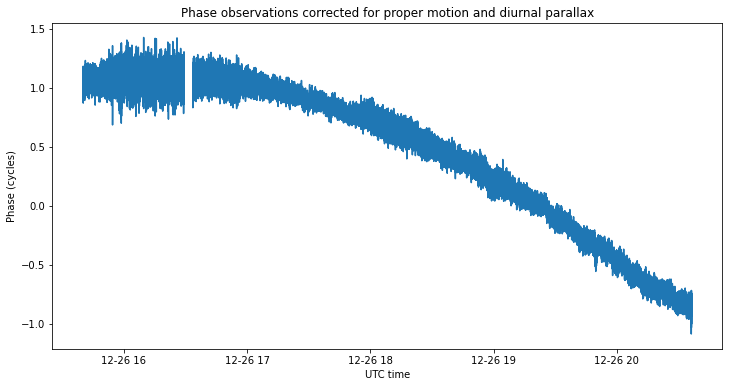

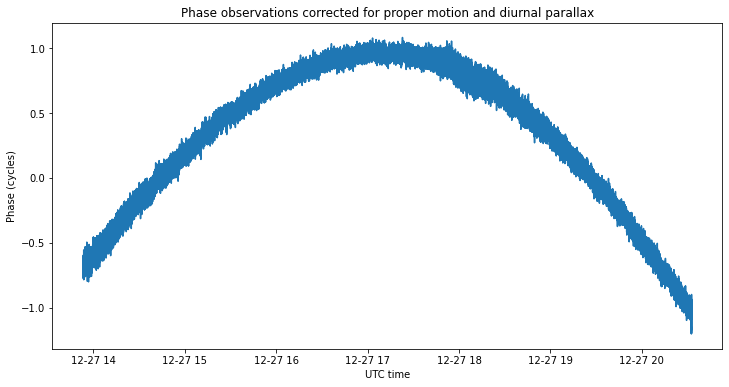

In [24]:
x_stop_corrected = {d : x_stop_unwrap[d] - pm_correction[d] - parallax_correction[d] for d in days}
for d in days:
    x_stop_corrected[d] -= np.round(np.nanmean(x_stop_corrected[d]))

for d in days:
    plt.figure()
    plt.plot(ts[d].datetime, x_stop_corrected[d])
    plt.title('Phase observations corrected for proper motion and diurnal parallax')
    plt.xlabel('UTC time')
    plt.ylabel('Phase (cycles)')

## Least squares solve for spacecraft position on the image plane

After correcting for the spacecraft movement on the image plane, we now can estimate the position of the spacecraft on the image plane, which should be interpreted as geocentric right ascension and declination at the beginning of the observation for each day.

The first step is estimate the position allowing a floating phase ambiguity. This means solving for $l$, $m$ and $C$ in
$$
lu(t) + mv(t) + C = \varphi(t),
$$
where $\varphi(t)$ are the unwrapped phase observations already corrected for proper motion and diurnal parallax, as plotted above.

In [25]:
solve0 = dict()
A0 = dict()
b0 = dict()
for d in days:
    sel = ~np.isnan(x_stop_corrected[d])
    A0[d] = np.empty((np.sum(sel), 3))
    A0[d][:,:2] = uvw[d][:2,sel].T/const.c*f_obs[d]
    A0[d][:,2] = 1
    b0[d] = x_stop_corrected[d][sel]
    solve0[d] = np.linalg.lstsq(A0[d], b0[d], rcond = None)

The residuals for this step are already small. There is some unmodelled oscillation in both days.

Text(0, 0.5, 'Phase (cycles)')

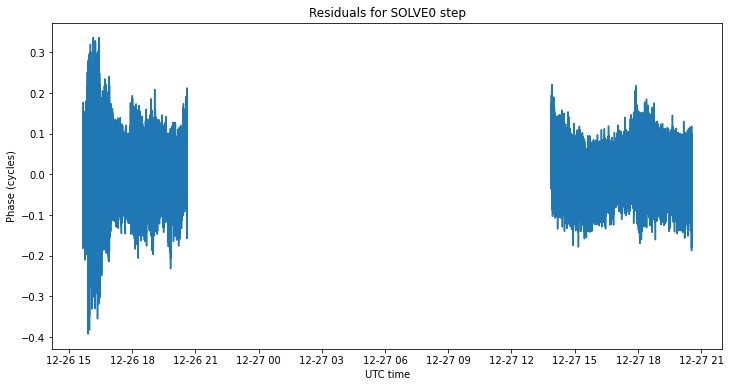

In [26]:
for d in days:
    plt.plot(ts[d][~np.isnan(x_stop_corrected[d])].datetime, b0[d] - A0[d] @ solve0[d][0],
            color = 'C0')
plt.title('Residuals for SOLVE0 step')
plt.xlabel('UTC time')
plt.ylabel('Phase (cycles)')

The solutions for $l$ and $m$ are smaller than the 0.2 degrees of expected accuracy for the phasing centre, so the solution looks good.

In [27]:
lm_deg_solve0 = {d : np.rad2deg(solve0[d][0][:2]) for d in days}
lm_deg_solve0

{26: array([-0.04376625,  0.08615803]), 27: array([-0.05641112,  0.18316206])}

In [28]:
floating_fixes = {d : solve0[d][0][-1] for d in days}
floating_fixes

{26: 1.791970883738506, 27: 4.625919655893178}

The next step is to replace the floating phase ambiguity $C$ by an integer and solve again, in order to try to obtain a fixed phase ambiguity fix.

In [29]:
solve1 = dict()
A1 = dict()
b1 = dict()
for d in days:
    sel = ~np.isnan(x_stop_corrected[d])
    A1[d] = np.empty((np.sum(sel), 2))
    A1[d][:,:] = uvw[d][:2,sel].T/const.c*f_obs[d]
    b1[d] = x_stop_corrected[d][sel] - np.round(solve0[d][0][-1])
    solve1[d] = np.linalg.lstsq(A1[d], b1[d], rcond = None)

The residuals look good again, indicating that an integer phase fix is possible.

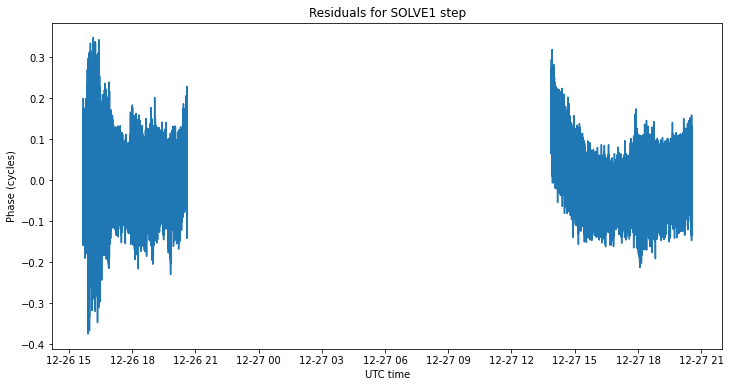

In [30]:
for d in days:
    plt.plot(ts[d][~np.isnan(x_stop_corrected[d])].datetime, b1[d] - A1[d] @ solve1[d][0],
            color = 'C0')
plt.title('Residuals for SOLVE1 step')
plt.xlabel('UTC time')
plt.ylabel('Phase (cycles)');

The $l$ and $m$ solutions have changed little compared to the previous step.

In [31]:
lm_deg_solve1 = {d : np.rad2deg(solve1[d][0][:2]) for d in days}
lm_deg_solve1

{26: array([-0.04491435,  0.0932858 ]), 27: array([-0.05942839,  0.19661744])}

In order to check if the integer phase fix is believable, we check near integer fixes (adding small integers to the phase fix) and plot the residuals.

The plot below uses a time averaging of 100 seconds so that the difference between the residuals for each fix can be seen easily.

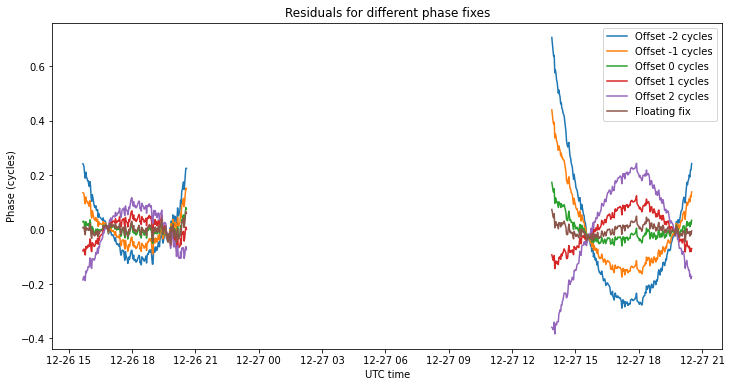

In [32]:
avg = 1000
solve_offset = {d : dict() for d in days}
for d in days:
    sel = ~np.isnan(x_stop_corrected[d])
    for j, offset in enumerate((-2, -1, 0, 1, 2)):
        b = b1[d] + offset
        solve_offset[d][offset] = np.linalg.lstsq(A1[d], b, rcond = None)
        res = b - A1[d] @ solve_offset[d][offset][0]
        res = np.average(res[:res.size//avg*avg].reshape((-1,avg)), axis = 1)
        tsavg = ts[d][sel]
        tsavg = tsavg[:tsavg.size//avg*avg][::avg]
        kwargs = dict()
        if d == 26:
            kwargs['label'] = f'Offset {offset} cycles'
        plt.plot(tsavg.datetime, res, color = f'C{j}', **kwargs)
    res = b0[d] - A0[d] @ solve0[d][0]
    res = np.average(res[:res.size//avg*avg].reshape((-1,avg)), axis = 1)
    if d == 26:
        kwargs['label'] = f'Floating fix'
    plt.plot(tsavg.datetime, res, color = f'C{j+1}', **kwargs)
plt.title('Residuals for different phase fixes')
plt.xlabel('UTC time')
plt.ylabel('Phase (cycles)')
plt.legend();

Below we plot the position of each solution in the image plane. We see that the integer fix solution with an offset of 0 cycles and the floating fix solution are close by. The other integer fix solutions are further away and they do not look believable, as seen from their larger residuals in the plot above.

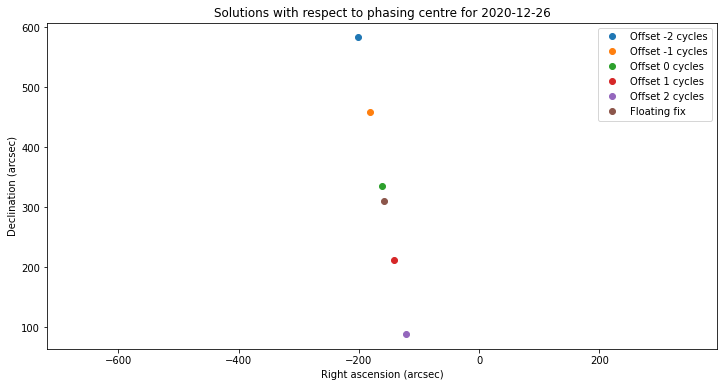

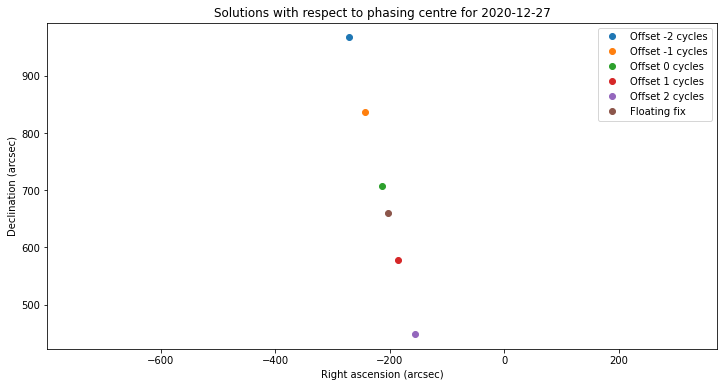

In [33]:
for d in days:
    plt.figure()
    for off,solve in solve_offset[d].items():
        plt.plot(np.rad2deg(solve[0][0]) * 3600, np.rad2deg(solve[0][1]) * 3600, 'o',
                 label = f'Offset {off} cycles')
    plt.plot(lm_deg_solve0[d][0] * 3600, lm_deg_solve0[d][1] * 3600, 'o',
            label = 'Floating fix')
    plt.axis('equal')
    plt.legend()
    plt.xlabel('Right ascension (arcsec)')
    plt.ylabel('Declination (arcsec)')
    plt.title(f'Solutions with respect to phasing centre for {day_names[d]}')

Below we show the difference in arcseconds between the floating fix and integer fix solutions, which is on the order of 10 arcseconds of right ascension and 50 arcseconds of declination.

In [34]:
{d : (lm_deg_solve0[d] - lm_deg_solve1[d]) * 3600 for d in days}

{26: array([  4.13318168, -25.65996461]),
 27: array([ 10.8621897 , -48.43938469])}

The integer fix solutions are neatly formatted below.

In [35]:
for d in days:
    print(ts[d][0].datetime, 'UTC -',
          'RA',
          (source[d].ra + lm_deg_solve1[d][0] * u.deg).to_string(unit = u.hourangle, format = 'unicode'),
         'DEC',
          (source[d].dec + lm_deg_solve1[d][1] * u.deg).to_string(format = 'unicode'))

2020-12-26 15:39:56.159047 UTC - RA 15ʰ18ᵐ50.4206ˢ DEC -13°31′54.1711″
2020-12-27 13:53:02.170753 UTC - RA 15ʰ20ᵐ22.9492ˢ DEC -13°49′42.1772″
